In [3]:
import geopandas as geo
import numpy as np
import pandas as pd

In [73]:
eennpp = gpd.read_file("..\\data\\eennpp.shp")
islas_canarias = gpd.read_file("..\\data\\islas_generalizadas.shp") 

In [6]:
eennpp.head()

,codigo,categoria,nombre,geometry
0,H-6,Paisaje Protegido,Ventejís,"POLYGON ((207380.300 3077264.524, 207361.430 3..."
1,H-7,Paisaje Protegido,Timijiraque,"POLYGON ((212318.690 3076408.720, 212322.130 3..."
2,H-3,Reserva Natural Especial,Tibataje,"POLYGON ((205028.180 3074960.459, 205020.849 3..."
3,H-2,Reserva Natural Integral,Roques de Salmor,"MULTIPOLYGON (((205086.150 3081134.320, 205088..."
4,H-5,Monumento Natural,Las Playas,"MULTIPOLYGON (((209998.290 3070692.910, 209998..."


In [103]:
islas_canarias.head()

,nombre,geometry
0,FUERTEVENTURA,"POLYGON ((614400.417 3179644.575, 614046.617 3..."
1,FUERTEVENTURA,"POLYGON ((589085.283 3152305.979, 589312.973 3..."
2,EL HIERRO,"POLYGON ((205260.539 3081076.767, 205665.090 3..."
3,TENERIFE,"POLYGON ((338109.671 3142160.390, 338626.550 3..."
4,LANZAROTE,"POLYGON ((645049.534 3254822.134, 645270.045 3..."


<Axes: >

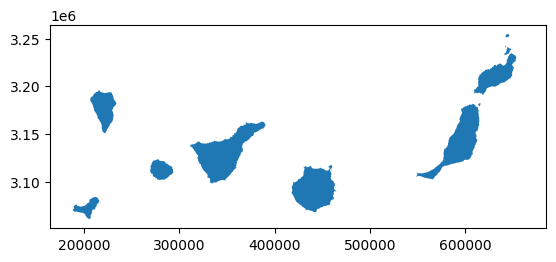

In [104]:
islas_canarias.plot()


In [107]:
filtro_generalizado = islas_canarias["nombre"] == "GRAN CANARIA"
gran_canaria_isla = islas_canarias[filtro_generalizado]
gran_canaria_isla

,nombre,geometry
10,GRAN CANARIA,"POLYGON ((430739.466 3110342.654, 430337.649 3..."


In [100]:
filtro = eennpp["codigo"].str.startswith("C")
eennp_pgran_canaria = eennpp[filtro]
eennp_pgran_canaria.head()

,codigo,categoria,nombre,geometry
20,C-32,Sitio de Interés Científico,Juncalillo del Sur,"POLYGON ((453679.696 3074570.097, 453669.984 3..."
21,C-31,Sitio de Interés Científico,Roque de Gando,"POLYGON ((464665.536 3090497.440, 464658.994 3..."
22,C-30,Sitio de Interés Científico,Tufia,"POLYGON ((462277.610 3093302.880, 462281.280 3..."
23,C-29,Sitio de Interés Científico,Jinámar,"POLYGON ((460256.224 3101297.088, 460260.274 3..."
24,C-28,Paisaje Protegido,Montaña de Agüimes,"POLYGON ((458220.295 3087279.345, 458220.210 3..."


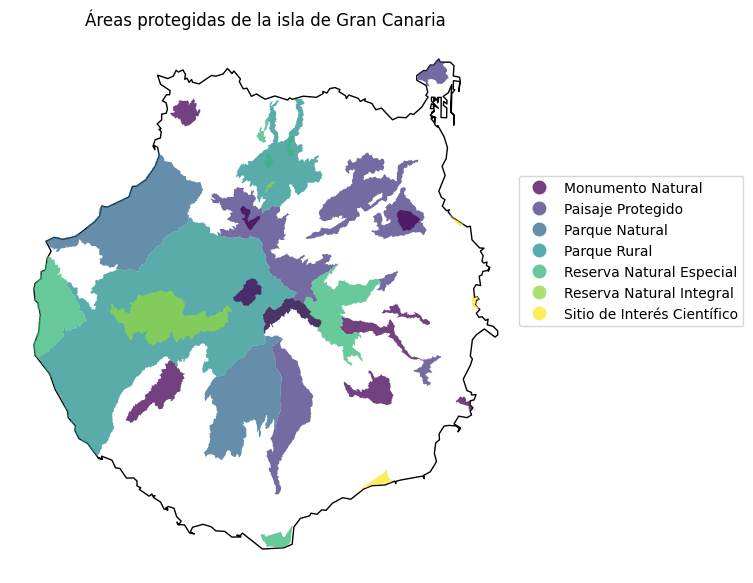

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

gran_canaria_isla.plot(ax=ax, facecolor='white', edgecolor="black")
plot = eennp_pgran_canaria.plot(column='categoria', legend=True, ax=ax, cmap='viridis', alpha = .75)
# Set axis labels and title
ax.set_title('Áreas protegidas de la isla de Gran Canaria')
leg = plot.get_legend()
leg.set_bbox_to_anchor((1.45, 0.75))
ax.set_axis_off()
